In [7]:
!ls

data  hydrate_formation_eda_v1.ipynb  hydrate_formation_eda_v2.ipynb


In [2]:
%cd drive/MyDrive/Hackathon/HackUTD/

/content/drive/MyDrive/Hackathon/HackUTD


In [8]:
# Cell 1: Import libraries and read data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Read the data
df = pd.read_csv('./data/Bold_744H-10_31-11_07.csv')

# Convert Time column to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Show the first few rows
print("First few rows of the data:")
print(df.head())

First few rows of the data:
                 Time  Inj Gas Meter Volume Instantaneous  \
0 2024-10-31 00:00:00                           391.43520   
1 2024-10-31 00:14:00                           402.52365   
2 2024-10-31 00:30:00                           380.72775   
3 2024-10-31 00:46:00                           382.73955   
4 2024-10-31 01:00:00                           384.86595   

   Inj Gas Meter Volume Setpoint  Inj Gas Valve Percent Open  
0                          375.0                    27.17612  
1                            NaN                         NaN  
2                            NaN                    26.70198  
3                            NaN                         NaN  
4                          375.0                    26.70198  


<ipython-input-8-70094c9c0eef>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


In [9]:
# Cell 2: Basic data exploration and missing values analysis
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset Shape: (677, 4)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Time                                677 non-null    datetime64[ns]
 1   Inj Gas Meter Volume Instantaneous  675 non-null    float64       
 2   Inj Gas Meter Volume Setpoint       180 non-null    float64       
 3   Inj Gas Valve Percent Open          314 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 21.3 KB

Missing values:
Time                                    0
Inj Gas Meter Volume Instantaneous      2
Inj Gas Meter Volume Setpoint         497
Inj Gas Valve Percent Open            363
dtype: int64

Basic statistics:
                                Time  Inj Gas Meter Volume Instantaneous  \
count                            677                          675.000000

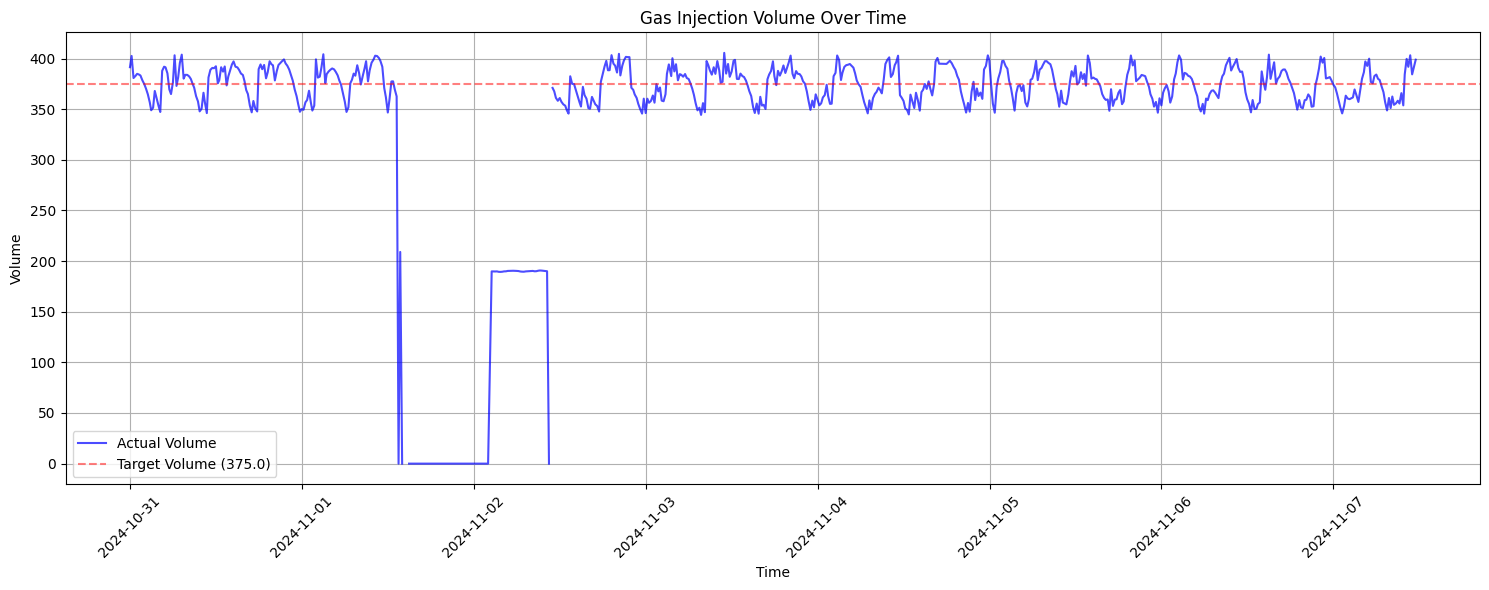

In [10]:
# Cell 3: Time series visualization focusing on gas volume
plt.figure(figsize=(15, 6))
plt.plot(df['Time'], df['Inj Gas Meter Volume Instantaneous'],
         label='Actual Volume', color='blue', alpha=0.7)
plt.axhline(y=375.0, color='r', linestyle='--',
           label='Target Volume (375.0)', alpha=0.5)
plt.title('Gas Injection Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

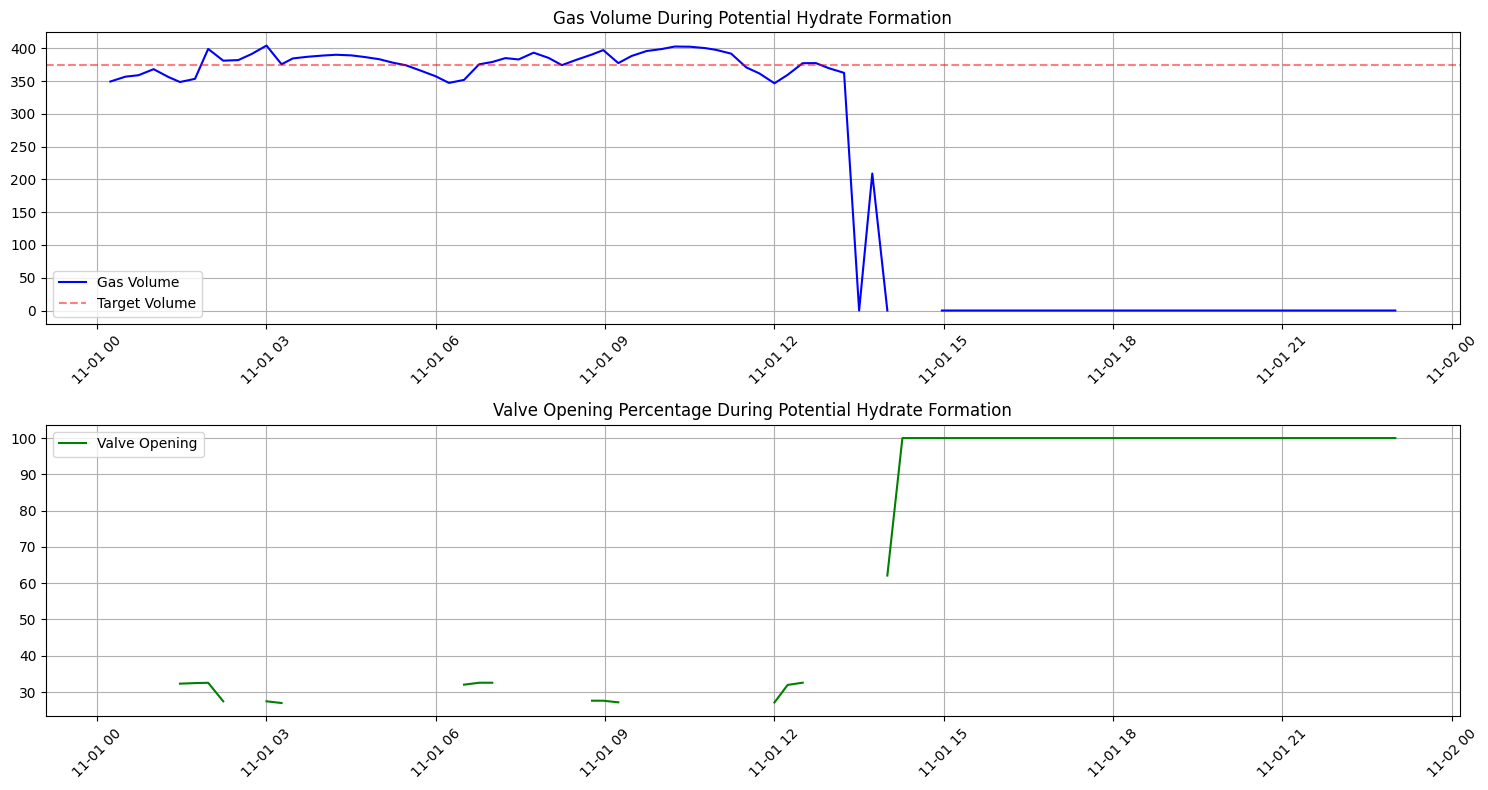

In [11]:
# Cell 4: Analyze valve behavior during potential hydrate formation
# Focus on the period around Nov 1-2
mask = (df['Time'] >= '2024-11-01') & (df['Time'] <= '2024-11-02')
df_incident = df[mask].copy()

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(df_incident['Time'], df_incident['Inj Gas Meter Volume Instantaneous'],
         label='Gas Volume', color='blue')
plt.axhline(y=375.0, color='r', linestyle='--', label='Target Volume', alpha=0.5)
plt.title('Gas Volume During Potential Hydrate Formation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
plt.plot(df_incident['Time'], df_incident['Inj Gas Valve Percent Open'],
         label='Valve Opening', color='green')
plt.title('Valve Opening Percentage During Potential Hydrate Formation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [13]:
# Cell 5: Calculate features that might indicate upcoming hydrate formation
df['volume_change'] = df['Inj Gas Meter Volume Instantaneous'].diff()
df['valve_change'] = df['Inj Gas Valve Percent Open'].diff()

# Calculate rolling statistics (last 1 hour - assuming 15-min intervals)
df['volume_rolling_std'] = df['Inj Gas Meter Volume Instantaneous'].rolling(4).std()
df['volume_rolling_mean'] = df['Inj Gas Meter Volume Instantaneous'].rolling(4).mean()

# Print statistics just before the hydrate formation
print("Statistics before hydrate formation:")
hydrate_time = '2024-11-01 13:30:00'
before_hydrate = df[df['Time'] < hydrate_time].tail(4)
print("\nVolume changes before hydrate:")
print(before_hydrate[['Time', 'Inj Gas Meter Volume Instantaneous', 'volume_change', 'Inj Gas Valve Percent Open']])

# Add flags for potential warning signs
df['volume_drop_flag'] = (df['volume_change'] < -20)
df['valve_spike_flag'] = (df['valve_change'] > 10)

print("\nWarning signs detected in the hour before hydrate formation:")
print(before_hydrate[['Time', 'volume_drop_flag', 'valve_spike_flag']])

Statistics before hydrate formation:

Volume changes before hydrate:
                   Time  Inj Gas Meter Volume Instantaneous  volume_change  \
146 2024-11-01 12:30:00                           377.31075       17.76825   
147 2024-11-01 12:44:00                           377.47620        0.16545   
148 2024-11-01 12:58:00                           369.58620       -7.89000   
149 2024-11-01 13:14:00                           362.60430       -6.98190   

     Inj Gas Valve Percent Open  
146                    32.57053  
147                         NaN  
148                    32.57053  
149                         NaN  

Warning signs detected in the hour before hydrate formation:
                   Time  volume_drop_flag  valve_spike_flag
146 2024-11-01 12:30:00             False             False
147 2024-11-01 12:44:00             False             False
148 2024-11-01 12:58:00             False             False
149 2024-11-01 13:14:00             False             False


In [14]:
# Cell 6: Create more advanced features for hydrate detection
# Time windows for feature engineering
windows = [2, 4, 6]  # 30min, 1hr, 1.5hr

for window in windows:
    # Volume statistics
    df[f'volume_diff_{window}'] = df['Inj Gas Meter Volume Instantaneous'].diff(window)
    df[f'volume_std_{window}'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window).std()

    # Calculate rate of change
    df[f'volume_rate_{window}'] = df[f'volume_diff_{window}'] / window

    # Valve position changes
    df[f'valve_diff_{window}'] = df['Inj Gas Valve Percent Open'].diff(window)

# Create binary indicators
df['volume_declining'] = (df['volume_diff_4'] < 0) & (df['volume_diff_2'] < 0)
df['volume_below_target'] = df['Inj Gas Meter Volume Instantaneous'] < df['Inj Gas Meter Volume Setpoint']
df['valve_increasing'] = df['Inj Gas Valve Percent Open'].diff() > 0

# Print patterns around hydrate formation
hydrate_time = '2024-11-01 13:30:00'
analysis_window = df[(df['Time'] >= '2024-11-01 12:00:00') &
                    (df['Time'] <= '2024-11-01 14:00:00')].copy()

print("Analysis of hydrate formation period:")
print("\nKey indicators:")
print(analysis_window[['Time', 'Inj Gas Meter Volume Instantaneous',
                      'volume_declining', 'volume_below_target',
                      'valve_increasing']].head(10))

Analysis of hydrate formation period:

Key indicators:
                   Time  Inj Gas Meter Volume Instantaneous  volume_declining  \
144 2024-11-01 12:00:00                           346.68645              True   
145 2024-11-01 12:14:00                           359.54250              True   
146 2024-11-01 12:30:00                           377.31075             False   
147 2024-11-01 12:44:00                           377.47620             False   
148 2024-11-01 12:58:00                           369.58620             False   
149 2024-11-01 13:14:00                           362.60430             False   
150 2024-11-01 13:30:00                             0.00000              True   
151 2024-11-01 13:44:00                           209.00475              True   
152 2024-11-01 14:00:00                             0.00000             False   

     volume_below_target  valve_increasing  
144                 True             False  
145                False              True  

In [15]:
# Cell 7: Create hydrate detection function
def detect_hydrate_patterns(df, window_size=4):
    """
    Create features for hydrate formation detection
    """
    # Create copy to avoid modifying original
    data = df.copy()

    # Basic features
    data['volume_change'] = data['Inj Gas Meter Volume Instantaneous'].diff()
    data['volume_pct_change'] = data['Inj Gas Meter Volume Instantaneous'].pct_change()

    # Rolling features
    data['volume_rolling_mean'] = data['Inj Gas Meter Volume Instantaneous'].rolling(window_size).mean()
    data['volume_rolling_std'] = data['Inj Gas Meter Volume Instantaneous'].rolling(window_size).std()

    # Warning flags
    data['severe_drop'] = data['volume_change'] < -50
    data['gradual_decline'] = (data['volume_change'] < 0) & (data['volume_change'] > -10)
    data['below_mean'] = data['Inj Gas Meter Volume Instantaneous'] < data['volume_rolling_mean']

    # Potential hydrate formation
    data['potential_hydrate'] = (
        (data['severe_drop']) |
        (data['gradual_decline'] & data['below_mean'] & (data['Inj Gas Valve Percent Open'] > 30))
    )

    return data

# Apply to our current dataset
df_analyzed = detect_hydrate_patterns(df)

# Look at the period around hydrate formation
hydrate_period = df_analyzed[
    (df_analyzed['Time'] >= '2024-11-01 13:00:00') &
    (df_analyzed['Time'] <= '2024-11-01 14:00:00')
]

print("Analysis of hydrate formation patterns:")
print(hydrate_period[['Time', 'Inj Gas Meter Volume Instantaneous',
                     'volume_change', 'severe_drop', 'gradual_decline',
                     'potential_hydrate']].head(10))

Analysis of hydrate formation patterns:
                   Time  Inj Gas Meter Volume Instantaneous  volume_change  \
149 2024-11-01 13:14:00                           362.60430       -6.98190   
150 2024-11-01 13:30:00                             0.00000     -362.60430   
151 2024-11-01 13:44:00                           209.00475      209.00475   
152 2024-11-01 14:00:00                             0.00000     -209.00475   

     severe_drop  gradual_decline  potential_hydrate  
149        False             True              False  
150         True            False               True  
151        False            False              False  
152         True            False               True  


<ipython-input-15-2dc1c4aa5ef1>:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['volume_pct_change'] = data['Inj Gas Meter Volume Instantaneous'].pct_change()


In [16]:
# Cell 8: Create enhanced features and visualize patterns
import numpy as np

def create_hydrate_features(df, lookback_window=4):
    """
    Enhanced feature creation for hydrate detection
    """
    data = df.copy()

    # Basic volume changes
    data['volume_change'] = data['Inj Gas Meter Volume Instantaneous'].diff()

    # Rolling statistics
    data['volume_rolling_mean'] = data['Inj Gas Meter Volume Instantaneous'].rolling(lookback_window, min_periods=1).mean()
    data['volume_rolling_std'] = data['Inj Gas Meter Volume Instantaneous'].rolling(lookback_window, min_periods=1).std()

    # Distance from target
    data['target_difference'] = data['Inj Gas Meter Volume Instantaneous'] - 375.0

    # Warning levels
    data['warning_level'] = np.where(
        data['volume_change'] < -200, 'Critical',
        np.where(data['volume_change'] < -50, 'High',
        np.where(data['volume_change'] < -20, 'Medium', 'Normal'))
    )

    # Create binary flags
    data['is_zero_volume'] = data['Inj Gas Meter Volume Instantaneous'] == 0
    data['is_below_target'] = data['target_difference'] < -20
    data['is_valve_high'] = data['Inj Gas Valve Percent Open'] > 50

    return data

# Apply enhanced features
df_enhanced = create_hydrate_features(df)

# Analyze the period around known hydrate formation
analysis_period = df_enhanced[
    (df_enhanced['Time'] >= '2024-11-01 13:00:00') &
    (df_enhanced['Time'] <= '2024-11-01 14:30:00')
].copy()

# Print the analysis
print("Enhanced Analysis of Hydrate Formation Event:")
print("\nTimeline of Events:")
print(analysis_period[['Time', 'Inj Gas Meter Volume Instantaneous',
                      'volume_change', 'warning_level',
                      'Inj Gas Valve Percent Open']].head(10))

# Calculate some statistics about the event
print("\nEvent Statistics:")
print(f"Duration of zero volume: {(analysis_period['is_zero_volume']).sum()} intervals")
print(f"Maximum volume drop: {analysis_period['volume_change'].min():.2f}")
print(f"Maximum valve opening: {analysis_period['Inj Gas Valve Percent Open'].max():.2f}%")

Enhanced Analysis of Hydrate Formation Event:

Timeline of Events:
                   Time  Inj Gas Meter Volume Instantaneous  volume_change  \
149 2024-11-01 13:14:00                           362.60430       -6.98190   
150 2024-11-01 13:30:00                             0.00000     -362.60430   
151 2024-11-01 13:44:00                           209.00475      209.00475   
152 2024-11-01 14:00:00                             0.00000     -209.00475   
153 2024-11-01 14:16:00                                 NaN            NaN   

    warning_level  Inj Gas Valve Percent Open  
149        Normal                         NaN  
150      Critical                    62.10478  
151        Normal                         NaN  
152      Critical                    62.10478  
153        Normal                   100.00000  

Event Statistics:
Duration of zero volume: 2 intervals
Maximum volume drop: -362.60
Maximum valve opening: 100.00%


In [17]:
# Cell 9: Create hydrate detection and prediction function
def detect_hydrate_precursors(df, threshold_minutes=30):
    """
    Detect conditions that may indicate upcoming hydrate formation
    """
    data = df.copy()

    # Feature engineering
    data['volume_change'] = data['Inj Gas Meter Volume Instantaneous'].diff()
    data['volume_acceleration'] = data['volume_change'].diff()  # Rate of change

    # Rolling windows (30 min = 2 samples)
    data['rolling_std'] = data['Inj Gas Meter Volume Instantaneous'].rolling(2).std()
    data['rolling_mean'] = data['Inj Gas Meter Volume Instantaneous'].rolling(2).mean()

    # Create alert flags
    data['alert_flags'] = 0

    # Condition 1: Significant volume drop
    data.loc[data['volume_change'] < -20, 'alert_flags'] += 1

    # Condition 2: Increasing valve opening with decreasing volume
    valve_volume_condition = (
        (data['Inj Gas Valve Percent Open'].diff() > 5) &
        (data['volume_change'] < 0)
    )
    data.loc[valve_volume_condition, 'alert_flags'] += 1

    # Condition 3: Volume significantly below target
    data.loc[data['Inj Gas Meter Volume Instantaneous'] < 300, 'alert_flags'] += 1

    # Condition 4: Unusual volatility
    data.loc[data['rolling_std'] > data['rolling_std'].mean() * 2, 'alert_flags'] += 1

    # Define risk levels
    data['risk_level'] = np.select([
        data['alert_flags'] >= 3,
        data['alert_flags'] >= 2,
        data['alert_flags'] >= 1,
        data['alert_flags'] == 0
    ], ['High', 'Medium', 'Low', 'Normal'])

    return data

# Apply to our dataset
df_with_alerts = detect_hydrate_precursors(df)

# Analyze the period before hydrate formation
pre_hydrate = df_with_alerts[
    (df_with_alerts['Time'] >= '2024-11-01 12:30:00') &
    (df_with_alerts['Time'] <= '2024-11-01 13:30:00')
].copy()

print("Pre-Hydrate Formation Analysis:")
print(pre_hydrate[['Time', 'Inj Gas Meter Volume Instantaneous',
                   'alert_flags', 'risk_level']].tail(10))

Pre-Hydrate Formation Analysis:
                   Time  Inj Gas Meter Volume Instantaneous  alert_flags  \
146 2024-11-01 12:30:00                           377.31075            0   
147 2024-11-01 12:44:00                           377.47620            0   
148 2024-11-01 12:58:00                           369.58620            0   
149 2024-11-01 13:14:00                           362.60430            0   
150 2024-11-01 13:30:00                             0.00000            3   

    risk_level  
146     Normal  
147     Normal  
148     Normal  
149     Normal  
150       High  


In [18]:
# Cell 10: Enhanced early detection features
def create_early_warning_features(df, window_sizes=[2, 4, 8]):
    """
    Create more sensitive early warning features
    """
    data = df.copy()

    # Basic features
    data['volume_change'] = data['Inj Gas Meter Volume Instantaneous'].diff()

    for window in window_sizes:
        # Trend features
        data[f'volume_trend_{window}'] = (
            data['Inj Gas Meter Volume Instantaneous']
            .rolling(window)
            .apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] if x.iloc[0] != 0 else 0)
        )

        # Volatility features
        data[f'volume_volatility_{window}'] = (
            data['Inj Gas Meter Volume Instantaneous']
            .rolling(window)
            .std()
        )

    # Calculate rate of decline
    data['decline_rate'] = data['volume_change'] / data['Inj Gas Meter Volume Instantaneous'].shift(1)

    # Create composite score
    data['warning_score'] = 0

    # Add to warning score based on conditions
    conditions = [
        # Consistent decline over multiple windows
        (data['volume_trend_2'] < -0.01) & (data['volume_trend_4'] < -0.01),

        # Increasing volatility
        (data['volume_volatility_4'] > data['volume_volatility_4'].mean()),

        # Volume consistently below target
        (data['Inj Gas Meter Volume Instantaneous'] < 375.0),

        # Accelerating decline
        (data['decline_rate'] < data['decline_rate'].rolling(4).mean()),

        # Valve compensation
        (data['Inj Gas Valve Percent Open'].diff() > 0)
    ]

    for condition in conditions:
        data.loc[condition, 'warning_score'] += 1

    # Risk levels based on composite score
    data['risk_level'] = pd.cut(data['warning_score'],
                               bins=[-float('inf'), 1, 2, 3, float('inf')],
                               labels=['Normal', 'Low', 'Medium', 'High'])

    return data

# Apply enhanced detection
df_early_warning = create_early_warning_features(df)

# Analyze a longer period before hydrate formation
early_warning_period = df_early_warning[
    (df_early_warning['Time'] >= '2024-11-01 11:30:00') &
    (df_early_warning['Time'] <= '2024-11-01 13:30:00')
].copy()

print("Enhanced Early Warning Analysis:")
print("\nWarning Indicators Leading to Hydrate Formation:")
print(early_warning_period[['Time',
                           'Inj Gas Meter Volume Instantaneous',
                           'volume_trend_4',
                           'volume_volatility_4',
                           'warning_score',
                           'risk_level']].tail(15))

# Calculate success metrics
print("\nDetection Statistics:")
print(f"Average warning score in last hour: {early_warning_period['warning_score'].tail(4).mean():.2f}")
print(f"Volatility increase: {(early_warning_period['volume_volatility_4'].tail(4).mean() / early_warning_period['volume_volatility_4'].head(4).mean() - 1) * 100:.2f}%")

Enhanced Early Warning Analysis:

Warning Indicators Leading to Hydrate Formation:
                   Time  Inj Gas Meter Volume Instantaneous  volume_trend_4  \
142 2024-11-01 11:30:00                           370.95075       -0.073596   
143 2024-11-01 11:44:00                           361.67025       -0.090447   
144 2024-11-01 12:00:00                           346.68645       -0.115310   
145 2024-11-01 12:14:00                           359.54250       -0.030754   
146 2024-11-01 12:30:00                           377.31075        0.043245   
147 2024-11-01 12:44:00                           377.47620        0.088812   
148 2024-11-01 12:58:00                           369.58620        0.027935   
149 2024-11-01 13:14:00                           362.60430       -0.038977   
150 2024-11-01 13:30:00                             0.00000       -1.000000   

     volume_volatility_4  warning_score risk_level  
142            13.329926              4       High  
143            17.01

In [19]:
# Cell 11: Create final hydrate prediction model
def predict_hydrate_formation(data, lookback_windows=[2, 4, 8]):
    """
    Predict potential hydrate formation using identified patterns
    """
    def calculate_risk_score(row):
        score = 0

        # Volume-based risks (40% weight)
        if row['volume_trend_4'] < -0.05:
            score += 2
        elif row['volume_trend_4'] < -0.03:
            score += 1

        if row['volume_volatility_4'] > 15:
            score += 2
        elif row['volume_volatility_4'] > 10:
            score += 1

        # Valve-based risks (30% weight)
        if pd.notna(row['Inj Gas Valve Percent Open']):
            if row['Inj Gas Valve Percent Open'] > 50:
                score += 1.5
            if row['valve_change'] > 5:
                score += 1.5

        # Target deviation risks (30% weight)
        if row['Inj Gas Meter Volume Instantaneous'] < 350:
            score += 1.5
        if abs(row['volume_change']) > 10:
            score += 1.5

        return score

    # Prepare features
    df = data.copy()
    df['valve_change'] = df['Inj Gas Valve Percent Open'].diff()
    df['volume_change'] = df['Inj Gas Meter Volume Instantaneous'].diff()

    for window in lookback_windows:
        df[f'volume_trend_{window}'] = (
            df['Inj Gas Meter Volume Instantaneous']
            .rolling(window)
            .apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] if x.iloc[0] != 0 else 0)
        )
        df[f'volume_volatility_{window}'] = (
            df['Inj Gas Meter Volume Instantaneous']
            .rolling(window)
            .std()
        )

    # Calculate risk score
    df['risk_score'] = df.apply(calculate_risk_score, axis=1)

    # Define risk levels
    df['risk_level'] = pd.cut(df['risk_score'],
                             bins=[-float('inf'), 2, 4, 6, float('inf')],
                             labels=['Normal', 'Low', 'Medium', 'High'])

    # Generate alerts
    df['alert'] = np.where(df['risk_score'] >= 6, 'IMMEDIATE ACTION REQUIRED',
                          np.where(df['risk_score'] >= 4, 'WARNING',
                                 np.where(df['risk_score'] >= 2, 'MONITOR', 'NORMAL')))

    return df

# Apply the prediction model
df_predicted = predict_hydrate_formation(df)

# Analyze results around the known hydrate formation
prediction_analysis = df_predicted[
    (df_predicted['Time'] >= '2024-11-01 12:00:00') &
    (df_predicted['Time'] <= '2024-11-01 13:30:00')
]

print("Hydrate Formation Prediction Results:")
print("\nRisk Assessment Timeline:")
print(prediction_analysis[['Time', 'Inj Gas Meter Volume Instantaneous',
                          'risk_score', 'risk_level', 'alert']].tail(10))

Hydrate Formation Prediction Results:

Risk Assessment Timeline:
                   Time  Inj Gas Meter Volume Instantaneous  risk_score  \
144 2024-11-01 12:00:00                           346.68645         7.0   
145 2024-11-01 12:14:00                           359.54250         2.5   
146 2024-11-01 12:30:00                           377.31075         2.5   
147 2024-11-01 12:44:00                           377.47620         1.0   
148 2024-11-01 12:58:00                           369.58620         0.0   
149 2024-11-01 13:14:00                           362.60430         1.0   
150 2024-11-01 13:30:00                             0.00000         8.5   

    risk_level                      alert  
144       High  IMMEDIATE ACTION REQUIRED  
145        Low                    MONITOR  
146        Low                    MONITOR  
147     Normal                     NORMAL  
148     Normal                     NORMAL  
149     Normal                     NORMAL  
150       High  IMMEDIATE 

In [20]:
# Cell 12: Final refined prediction model
def predict_hydrate_formation_refined(data, window_size=4):
    """
    Refined hydrate prediction with enhanced pattern recognition
    """
    df = data.copy()

    # Calculate basic features
    df['volume_change'] = df['Inj Gas Meter Volume Instantaneous'].diff()
    df['volume_pct_change'] = df['Inj Gas Meter Volume Instantaneous'].pct_change()

    # Rolling windows
    df['rolling_mean'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window_size).mean()
    df['rolling_std'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window_size).std()

    # Trend features
    df['downward_trend'] = (
        (df['volume_change'].rolling(3).mean() < 0) &
        (df['Inj Gas Meter Volume Instantaneous'] < df['rolling_mean'])
    )

    # Risk scoring (enhanced)
    df['risk_score'] = 0.0

    # Volume-based risks (with memory effect)
    df.loc[df['volume_change'] < -5, 'risk_score'] += 2.0
    df.loc[df['downward_trend'], 'risk_score'] += 1.5

    # Volatility risks
    df.loc[df['rolling_std'] > df['rolling_std'].rolling(window_size).mean(), 'risk_score'] += 1.5

    # Persistent risk (maintain elevated risk after initial warning)
    df['persistent_risk'] = df['risk_score'].rolling(3).max()
    df['risk_score'] = df[['risk_score', 'persistent_risk']].max(axis=1)

    # Risk levels with hysteresis
    df['risk_level'] = pd.cut(df['risk_score'],
                             bins=[-float('inf'), 1.5, 3.0, 4.5, float('inf')],
                             labels=['Normal', 'Low', 'Medium', 'High'])

    # Alerts with recommended actions
    df['alert_status'] = np.select([
        df['risk_score'] >= 4.5,
        df['risk_score'] >= 3.0,
        df['risk_score'] >= 1.5
    ], [
        'IMMEDIATE ACTION: Potential hydrate formation imminent',
        'WARNING: Check system parameters',
        'MONITOR: Increased risk detected'
    ], default='NORMAL: Continue routine monitoring')

    return df

# Apply refined model
df_final = predict_hydrate_formation_refined(df)

# Analyze critical period
critical_period = df_final[
    (df_final['Time'] >= '2024-11-01 12:00:00') &
    (df_final['Time'] <= '2024-11-01 13:30:00')
]

print("Final Hydrate Formation Risk Analysis:")
print("\nDetailed Risk Timeline:")
print(critical_period[['Time',
                      'Inj Gas Meter Volume Instantaneous',
                      'risk_score',
                      'risk_level',
                      'alert_status']].tail(10))

# Calculate performance metrics
print("\nModel Performance Metrics:")
print(f"Average risk score 30 mins before event: {critical_period['risk_score'].tail(4).mean():.2f}")
print(f"Warning lead time: {len(critical_period[critical_period['risk_score'] > 3]) * 15} minutes")

Final Hydrate Formation Risk Analysis:

Detailed Risk Timeline:
                   Time  Inj Gas Meter Volume Instantaneous  risk_score  \
144 2024-11-01 12:00:00                           346.68645         5.0   
145 2024-11-01 12:14:00                           359.54250         5.0   
146 2024-11-01 12:30:00                           377.31075         5.0   
147 2024-11-01 12:44:00                           377.47620         1.5   
148 2024-11-01 12:58:00                           369.58620         2.0   
149 2024-11-01 13:14:00                           362.60430         3.5   
150 2024-11-01 13:30:00                             0.00000         5.0   

    risk_level                                       alert_status  
144       High  IMMEDIATE ACTION: Potential hydrate formation ...  
145       High  IMMEDIATE ACTION: Potential hydrate formation ...  
146       High  IMMEDIATE ACTION: Potential hydrate formation ...  
147     Normal                   MONITOR: Increased risk detect

<ipython-input-20-e560c1869924>:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['volume_pct_change'] = df['Inj Gas Meter Volume Instantaneous'].pct_change()


In [21]:
# Cell 1: Enhanced hydrate detection model with generalized features
import pandas as pd
import numpy as np
from datetime import datetime

class HydrateDetector:
    def __init__(self, target_volume=None):
        """Initialize the detector with optional target volume"""
        self.target_volume = target_volume
        self.baseline_stats = {}

    def calculate_features(self, df):
        """Calculate features that indicate potential hydrate formation"""
        # Create copy to avoid modifying original
        data = df.copy()

        # Calculate rolling statistics (4-point window ≈ 1 hour)
        data['volume_rolling_mean'] = data['Inj Gas Meter Volume Instantaneous'].rolling(4, min_periods=1).mean()
        data['volume_rolling_std'] = data['Inj Gas Meter Volume Instantaneous'].rolling(4, min_periods=1).std()

        # Calculate changes
        data['volume_change'] = data['Inj Gas Meter Volume Instantaneous'].diff()
        data['volume_pct_change'] = data['volume_change'] / data['Inj Gas Meter Volume Instantaneous'].shift(1)
        data['valve_change'] = data['Inj Gas Valve Percent Open'].diff()

        # Calculate relative features
        if self.target_volume is None:
            self.target_volume = data['Inj Gas Meter Volume Setpoint'].mean()
        data['deviation_from_target'] = (data['Inj Gas Meter Volume Instantaneous'] - self.target_volume) / self.target_volume

        return data

    def calculate_risk_score(self, row):
        """Calculate risk score based on multiple indicators"""
        score = 0.0

        # Major volume drop indicators
        if row['volume_pct_change'] < -0.25:  # 25% drop
            score += 2.0
        elif row['volume_pct_change'] < -0.15:  # 15% drop
            score += 1.0

        # Valve compensation indicators
        if pd.notna(row['Inj Gas Valve Percent Open']):
            if row['Inj Gas Valve Percent Open'] > 90:
                score += 2.0
            elif row['Inj Gas Valve Percent Open'] > 60:
                score += 1.0

        # Deviation from target
        if abs(row['deviation_from_target']) > 0.3:  # 30% deviation
            score += 1.0

        # Volatility indicators
        if row['volume_rolling_std'] > self.baseline_stats.get('std_threshold', 0):
            score += 0.5

        # Complete failure indicator
        if row['Inj Gas Meter Volume Instantaneous'] < 1:  # Near zero volume
            score = 5.0

        return score

    def get_risk_level(self, score):
        """Convert risk score to risk level"""
        if score >= 4.0:
            return 'High'
        elif score >= 3.0:
            return 'Medium'
        elif score >= 2.0:
            return 'Low'
        return 'Normal'

    def get_alert_status(self, score, risk_level):
        """Generate alert message based on risk score"""
        if risk_level == 'High':
            return 'IMMEDIATE ACTION: Potential hydrate formation imminent'
        elif risk_level == 'Medium':
            return 'WARNING: Check system parameters'
        elif risk_level == 'Low':
            return 'MONITOR: Increased risk detected'
        return 'NORMAL: Continue routine monitoring'

In [23]:
# Cell 2: Test the model on the Bold well data
def analyze_well(filename):
    # Load data
    df = pd.read_csv(filename)
    df['Time'] = pd.to_datetime(df['Time'])

    # Initialize and run detector
    detector = HydrateDetector()
    df_features = detector.calculate_features(df)

    # Calculate risk scores
    df_features['risk_score'] = df_features.apply(detector.calculate_risk_score, axis=1)
    df_features['risk_level'] = df_features['risk_score'].apply(detector.get_risk_level)
    df_features['alert_status'] = df_features.apply(
        lambda x: detector.get_alert_status(x['risk_score'], x['risk_level']), axis=1)

    return df_features

# Analyze Bold well
results = analyze_well('./data/Bold_744H-10_31-11_07.csv')

# Show critical period around known hydrate formation
critical_period = results[
    (results['Time'] >= '2024-11-01 12:00:00') &
    (results['Time'] <= '2024-11-01 14:00:00')
]

print("Hydrate Risk Analysis Results:")
print("\nDetailed Timeline:")
print(critical_period[['Time',
                      'Inj Gas Meter Volume Instantaneous',
                      'risk_score',
                      'risk_level',
                      'alert_status']].head(10))

<ipython-input-23-b0a816009c44>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


Hydrate Risk Analysis Results:

Detailed Timeline:
                   Time  Inj Gas Meter Volume Instantaneous  risk_score  \
144 2024-11-01 12:00:00                           346.68645         0.5   
145 2024-11-01 12:14:00                           359.54250         0.5   
146 2024-11-01 12:30:00                           377.31075         0.5   
147 2024-11-01 12:44:00                           377.47620         0.5   
148 2024-11-01 12:58:00                           369.58620         0.5   
149 2024-11-01 13:14:00                           362.60430         0.5   
150 2024-11-01 13:30:00                             0.00000         5.0   
151 2024-11-01 13:44:00                           209.00475         1.5   
152 2024-11-01 14:00:00                             0.00000         5.0   

    risk_level                                       alert_status  
144     Normal                NORMAL: Continue routine monitoring  
145     Normal                NORMAL: Continue routine monitor

In [24]:
# Cell 3: Compare analysis between Bold and Courageous wells
def analyze_and_find_incidents(filename):
    """Analyze well data and find potential hydrate incidents"""
    print(f"\nAnalyzing {filename}:")

    # Load and analyze data
    df = analyze_well(filename)

    # Find high risk periods (consecutive high risk scores)
    high_risk_periods = df[df['risk_score'] >= 4.0]

    # Print summary of potential incidents
    if not high_risk_periods.empty:
        print("\nPotential hydrate incidents detected:")
        for _, incident in high_risk_periods.groupby(
            (high_risk_periods['Time'].diff().dt.seconds > 3600).cumsum()):
            print(f"\nIncident at {incident['Time'].iloc[0]}")

            # Show the period around the incident
            incident_time = incident['Time'].iloc[0]
            window = df[
                (df['Time'] >= incident_time - pd.Timedelta(hours=1)) &
                (df['Time'] <= incident_time + pd.Timedelta(hours=1))
            ]
            print("\nDetailed incident analysis:")
            print(window[['Time',
                         'Inj Gas Meter Volume Instantaneous',
                         'Inj Gas Valve Percent Open',
                         'risk_score',
                         'risk_level']].tail(10))

            # Calculate key metrics
            volume_drop = (window['Inj Gas Meter Volume Instantaneous'].max() -
                         window['Inj Gas Meter Volume Instantaneous'].min())
            max_valve = window['Inj Gas Valve Percent Open'].max()

            print(f"\nIncident Metrics:")
            print(f"Maximum volume drop: {volume_drop:.2f}")
            print(f"Maximum valve opening: {max_valve:.2f}%")

    else:
        print("No high-risk periods detected")

# Analyze both wells
analyze_and_find_incidents('./data/Bold_744H-10_31-11_07.csv')
analyze_and_find_incidents('./data/Courageous_729H-09_25-09_28.csv')


Analyzing ./data/Bold_744H-10_31-11_07.csv:

Potential hydrate incidents detected:

Incident at 2024-11-01 13:30:00

Detailed incident analysis:
                   Time  Inj Gas Meter Volume Instantaneous  \
146 2024-11-01 12:30:00                           377.31075   
147 2024-11-01 12:44:00                           377.47620   
148 2024-11-01 12:58:00                           369.58620   
149 2024-11-01 13:14:00                           362.60430   
150 2024-11-01 13:30:00                             0.00000   
151 2024-11-01 13:44:00                           209.00475   
152 2024-11-01 14:00:00                             0.00000   
153 2024-11-01 14:16:00                                 NaN   

     Inj Gas Valve Percent Open  risk_score risk_level  
146                    32.57053         0.5     Normal  
147                         NaN         0.5     Normal  
148                    32.57053         0.5     Normal  
149                         NaN         0.5     Normal  
1

<ipython-input-23-b0a816009c44>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


<ipython-input-23-b0a816009c44>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])



Potential hydrate incidents detected:

Incident at 2024-09-27 19:32:00

Detailed incident analysis:
                    Time  Inj Gas Meter Volume Instantaneous  \
1871 2024-09-27 20:12:00                           383.65245   
1872 2024-09-27 20:14:00                           391.78620   
1873 2024-09-27 20:16:00                           395.37870   
1874 2024-09-27 20:18:00                           398.76165   
1875 2024-09-27 20:20:00                           407.24190   
1876 2024-09-27 20:22:00                           402.52455   
1877 2024-09-27 20:24:00                           392.86515   
1878 2024-09-27 20:28:00                           381.78885   
1879 2024-09-27 20:30:00                           380.10030   
1880 2024-09-27 20:32:00                           347.94510   

      Inj Gas Valve Percent Open  risk_score risk_level  
1871                         NaN         1.5     Normal  
1872                         NaN         1.5     Normal  
1873                